# Notebook for the testing of the Teresa Robot
## Importing all necessary tools

In [1]:
import roslibpy # Communication with the HMI
import time 
from src.gym_envs.RobotEnv_ import RobotEnv # Training environment
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import roslibpy # API of ROS
from src.robots.Teresa_adap import Teresa # This is the representation of Teresa Robot
from src.utils.training_tools import NB_STATES
from src.robots.actions.camera_adap import DlinkDCSCamera # class for the camera
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import cv2
import logging
import requests

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from src.tests.FormulaTests import FormulaTests

## Creating the connection with ROS

In [3]:
#ip_ordi : 192.168.1.50

client = roslibpy.Ros(host="192.168.1.14", port=9090)
client.run()
print(client.is_connected)

True


## Creating the connection with the camera

In [4]:
host='192.168.1.35'
user='admin'
password='123456'
camera = DlinkDCSCamera(host = host, user = user, password = password)
camera.set_day_night(2)

{'DayNightMode': '2',
 'LightSensorControl': '3',
 'IRLedScheduleSunStart': '00:00',
 'IRLedScheduleSunEnd': '00:00',
 'IRLedScheduleMonStart': '00:00',
 'IRLedScheduleMonEnd': '00:00',
 'IRLedScheduleTueStart': '00:00',
 'IRLedScheduleTueEnd': '00:00',
 'IRLedScheduleWedStart': '00:00',
 'IRLedScheduleWedEnd': '00:00',
 'IRLedScheduleThuStart': '00:00',
 'IRLedScheduleThuEnd': '00:00',
 'IRLedScheduleFriStart': '00:00',
 'IRLedScheduleFriEnd': '00:00',
 'IRLedScheduleSatStart': '00:00',
 'IRLedScheduleSatEnd': '00:00'}

## Controlling the robot from the jupyternotebook

In [6]:
client.run()
teresa_controller = Teresa(client)
env = RobotEnv(teresa_controller, client)

env.reset()
finish = False

while not finish:
    movement = input('Enter a movement (0 Right, 1 Left, 2 Backward, 3 Forward, exit): ')
    if movement == 'exit':
        finish = True
        continue
    movement = int(movement)
    state, reward, done, _ = env.step(movement)
    if done and reward:
        print("Centered")
        #env.reset()
    env.render()

Enter a movement (0 Right, 1 Left, 2 Backward, 3 Forward, exit): 0
{'angular': {'z': 0.778}}
[[519 260  23  46]]
Enter a movement (0 Right, 1 Left, 2 Backward, 3 Forward, exit): 3
{'linear': {'x': 0.5}}
[[376 196  51  51]]
Centered
Enter a movement (0 Right, 1 Left, 2 Backward, 3 Forward, exit): exit


### TESTING the camera output to adjust the resolution

In [7]:
client.run() # This run the main loop of ROS
teresa_controller = Teresa(client) # Robot API
env = RobotEnv(teresa_controller, client) # Training Environment


action=0
env.step(action)
env.render()
env.step(1)
env.render()


{'angular': {'z': 0.778}}
[[ 44 712  32  64]]
{'angular': {'z': -0.778}}
[[337 184  51  51]]


0

### Calibration of the robot

In [8]:
from src.utils.training_tools import OBSERVATION_FILE, IMAGE_SIZE, SQUARE_SIZE_X, SQUARE_SIZE_Y, STEP_X, STEP_Y, ERROR, FINAL_X, FINAL_Y

def calibration():
    # put the robot in front the person in any position you want
    #this function will center the camera of the robot on the person
    env.step(0)
    env.render()
    face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
    
    x_1, y_1, x_2, y_2, x_desired, y_desired, w_desired, h_desired, c_done = define_rectangles(face_cascade)
    
    
    if (x_1 + y_1 + x_2 + y_2 + x_desired + y_desired + w_desired + h_desired)== 0:
        print('person not detected')
    else:
        #(0 Right, 1 Left, 2 Backward, 3 Forward)
        while c_done:
            #condition the robot is too much on the right
            while (x_desired > x_1):
                print('right')#regrding the robot, the robot will turn left
                env.step(0)
                env.render()
                x_1, y_1, x_2, y_2, x_desired, y_desired, w_desired, h_desired, c_done = define_rectangles(face_cascade)
            #condition the robot is too much on the left
            while (x_desired+w_desired < x_2):
                print('left')
                env.step(1)
                env.render()
                x_1, y_1, x_2, y_2, x_desired, y_desired, w_desired, h_desired,c_done = define_rectangles( face_cascade)
            #condition on the top and the bottom of the rectangle
            while ((y_desired > y_1) or (y_desired+h_desired < y_2)):
                print('backward')
                env.step(2)
                env.render()
                x_1, y_1, x_2, y_2, x_desired, y_desired, w_desired, h_desired, c_done = define_rectangles(face_cascade)
            if (x_desired < x_1) and (x_desired+w_desired > x_2) and ((y_desired < y_1) or (y_desired+h_desired > y_2)):
                c_done=False
                print('finish')
    
def define_rectangles(face_cascade):
    image = cv2.imread('env_observation.jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    object_locations=face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(object_locations)>0:
        x, y, w, h = object_locations[0]
        x_1 = x-w #top left of the rectangle
        y_1 = y-h #top left of the rectangle
        x_2 = x+2*w #bottom right of the rectangle
        y_2 = y+8*h #bottom rigth of the rectangle
        
        x_desired,y_desired = FINAL_X, FINAL_Y # 70 added for the wanted rectangle to be a bit lower
        w_desired = SQUARE_SIZE_X
        h_desired = SQUARE_SIZE_Y
        cv2.rectangle(image,(x_1,y_1),(x_2,y_2),(255,0,0),2)
        cv2.rectangle(image, (x_desired, y_desired), (x_desired+w_desired, y_desired+h_desired), (25, 125, 225), 5)

        cv2.imshow('image', image)
        cv2.waitKey(1)
        return x_1, y_1, x_2, y_2, x_desired, y_desired, w_desired, h_desired, True
    else:
        print('person not detected')
        env.render()
        return 0,0,0,0,0,0,0,0, False

In [ ]:
calibration()

## Test the commands sent to the robot

In [5]:
import roslibpy
import time

from src.utils.training_tools import EXECUTION_TIME

STOP_ROBOT = {
    'linear': {
        'y': 0.0, 
        'x': 0.0, 
        'z': 0.0
    }, 
    'angular': {
        'y': 0.0, 
        'x': 0.0, 
        'z': 0.0
    }
}


'''
Publish the move to the ros topic to execute it
'''
def execute_move(move_msg, move_topic):
    #move_msg = movements[move] # Get the ROS message for the move selected
    print(move_msg)
    # Execute the move
    move_topic.publish(roslibpy.Message(move_msg))
    time.sleep(EXECUTION_TIME)
    move_topic.publish(roslibpy.Message(STOP_ROBOT))
    time.sleep(EXECUTION_TIME)
    
    
    

'''
Test
'''
# NB: for a rotation of 0.5 the robot doesn't turn around 0.75 seems to be a good value
move_topic = {
        'topic_name': '/cmd_vel',
        'msg_type': 'geometry_msgs/Twist'
    }
move_topic = roslibpy.Topic(client, move_topic['topic_name'], move_topic['msg_type'])
move_msg={'angular': {'z': -0.75}} # change this line to test oder command

execute_move(move_msg, move_topic)

{'angular': {'z': -0.75}}


### Testing the haarcasaced filter on images
(the filter don't have an sufficiently high accuracy for reinforcement learning)

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_eye.xml')
body_cascade = cv2.CascadeClassifier('Haarcascades/haarcascade_fullbody.xml')

img = cv2.imread('env_observation.jpg') #enter the file name to test
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
body=body_cascade.detectMultiScale(gray,1.2,3)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x-w,y-h),(x+2*w,y+11*h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

x_desired,y_desired = FINAL_X, FINAL_Y
w_desired = SQUARE_SIZE_X
h_desired = SQUARE_SIZE_Y

cv2.rectangle(img, (x_desired, y_desired), (x_desired+w_desired, y_desired+h_desired), (25, 125, 225), 5)


cv2.imshow('img',img)
#type 0 to quit the window
cv2.waitKey(0)

NameError: name 'FINAL_X' is not defined

In [ ]:
faces

## Testing the Neural Network

### Structure of the NN

In [5]:
NbStat = NB_STATES
state_size = NbStat
action_size = 4
# new_graph = tf.Graph()
initializer=tf.initializers.glorot_uniform()
learning_rate = 0.01

def discount_correct_rewards(r, gamma=0.99):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    #if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add

  discounted_r -= discounted_r.mean()
  discounted_r /- discounted_r.std()
  return discounted_r

def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    #print("len episode rewards",episode_rewards)
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        #print("dans boucle",episode_rewards[i],"cyl",cumulative)
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    if std :
        discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    else:
        discounted_episode=[]
        discounted_episode_rewards[0] = np.array(mean)
        print("ATTTTTTTTTTTTTTTTTT")
    #print("dis",discounted_episode_rewards,"std",std)
    
    return discounted_episode_rewards

with tf.name_scope("inputs"):
    input_ = tf.placeholder(tf.float32, [None, state_size], name="input_")
    actions = tf.placeholder(tf.int32, [None, action_size], name="actions")
    discounted_episode_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episode_rewards")
    
    # Add this placeholder for having this variable in tensorboard
    mean_reward_ = tf.placeholder(tf.float32 , name="mean_reward")

    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(input_ , 20, activation=tf.nn.relu,kernel_initializer=initializer)

    with tf.name_scope("fc2"):
        fc2 = tf.layers.dense(fc1, action_size,activation= tf.nn.relu, kernel_initializer=initializer)
    
    with tf.name_scope("fc3"):
        fc3 = tf.layers.dense(fc2, action_size, activation= None,kernel_initializer=initializer)

    with tf.name_scope("softmax"):
        action_distribution = tf.nn.softmax(fc3)

    with tf.name_scope("loss"):
        # tf.nn.softmax_cross_entropy_with_logits computes the cross entropy of the result after applying the softmax function
        # If you have single-class labels, where an object can only belong to one class, you might now consider using 
        # tf.nn.sparse_softmax_cross_entropy_with_logits so that you don't have to convert your labels to a dense one-hot array. 
        neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = fc3, labels = actions)
        #loss = tf.nn.sparse_softmax_cross_entropy_with_logits (neg_log_prob * discounted_episode_rewards_)
        loss = tf.reduce_mean(neg_log_prob * discounted_episode_rewards_) 
        
    
    with tf.name_scope("train"):
        train_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# Setup TensorBoard Writer


## Losses
## TRAINING Hyperparameters

# tf.summary.scalar("Loss", loss)

# ## Reward mean
# tf.summary.scalar("Reward_mean", mean_reward_)

max_episodes = 500

gamma = 0.95 # Discount rate
max_batch = NbStat*5
    
episode_rewards_sum = 0

        # Launch the game
    #state = env.reset()
    #ne_state=np.identity(NbStat)[state:state+1]
    #env.render()
episode_length=0

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


### Running the NN

In [6]:
saver = tf.train.Saver()

client.run() # This run the main loop of ROS
teresa_controller = Teresa(client) # Robot API
env = RobotEnv(teresa_controller, client) # Training Environment
with tf.Session() as sess:
    # sess.run(tf.global_variables_initializer())
   
        # Load the model
    print(saver.restore(sess, "pgpendul.ckpt"))
    # if not saver.restore(sess, "pgpendul.ckpt"):
    #     print()
    total_rewards = 0
    rewards = []

    for episode in range(100):
        state = env.reset()
        #ne_state=np.identity(NbStat)[state:state+1]
        step = 0
        done = False
        
        print("****************************************************")
        print("EPISODE ", episode)

       
        #while True:
        j = 0
        #The Q-Network
        while j < 10:
            j+=1
            state=int(state)
            ne_state=np.identity(NbStat)[state:state+1]
            # Choose action a, remember WE'RE NOT IN A DETERMINISTIC ENVIRONMENT, WE'RE OUTPUT PROBABILITIES.
            action_probability_distribution = sess.run(action_distribution, feed_dict={input_: ne_state.reshape([1,NbStat])})
            print(action_probability_distribution)
            action = np.random.choice(range(action_probability_distribution.shape[1]), p=action_probability_distribution.ravel())  # select action w.r.t the actions prob
            #action = np.argmax(action_probability_distribution)
            
            
            # new_state, reward, done, info = env.step(int(action),True)
            new_state, reward, done, info = env.step(int(action))
            env.render()

            print("state",state,"ne_state",new_state,"action",action) 
            total_rewards += reward
            if done:    
                rewards.append(total_rewards)
                print ("Score", total_rewards)
                break
            state = new_state
    env.close()
print ("Score over time: " ,  total_rewards)

INFO:tensorflow:Restoring parameters from pgpendul.ckpt
None
****************************************************
EPISODE  0
[[0.2573676  0.24735928 0.2543879  0.2408852 ]]
{'linear': {'x': 0.5}}
[[308 176  50  50]]
state 0 ne_state 2016 action 3
Score 1
****************************************************
EPISODE  1
[[0.2573676  0.24735928 0.2543879  0.2408852 ]]
{'angular': {'z': -0.778}}
[[160 157  52  52]]
state 0 ne_state 1757 action 1
[[0.2541288  0.24532402 0.24917848 0.2513687 ]]
{'linear': {'x': -0.5}}
[[178 169  50  50]
 [629 212  52  52]]
state 1757 ne_state 1875 action 2
[[0.25623852 0.24780703 0.25260502 0.24334939]]
{'angular': {'z': -0.778}}
[[117 166  49  49]]
state 1875 ne_state 1863 action 1
[[0.255789   0.24721444 0.24684177 0.2501547 ]]
{'linear': {'x': -0.5}}
[[113 175  47  47]]
state 1863 ne_state 1977 action 2
[[0.25496715 0.24492182 0.25335503 0.24675599]]
{'angular': {'z': -0.778}}
[[ 86 165  48  48]]
state 1977 ne_state 1857 action 1
[[0.2545836  0.2480021  0.

KeyboardInterrupt: 

In [7]:
client.terminate()

### Plot of the rewards according to the episodes

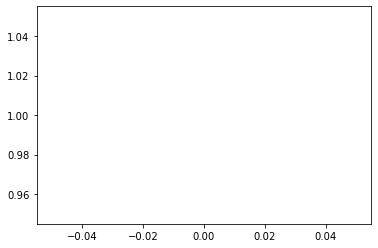

In [8]:
from matplotlib import pyplot as plt
plt.plot(rewards)
plt.show()